In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from pygrid3 import grid_kernel, pygrid
from gen_phantom import gen_phantom

In [2]:
gg = pygrid.Gridder(imsize=(100,256,256), over_samp=1.5, krad=1.5, grid_mod = 32)

In [3]:
np.random.seed(10)

N_proj = 200000

r = np.linspace(-0.5, 0.5, 512)
r = r.reshape(1, -1)

theta = 2.0 * np.pi * np.random.random(N_proj)
phi = np.arccos(1.0 - 2.0 * np.random.random(N_proj))
theta = theta.reshape(-1, 1)
phi = phi.reshape(-1, 1)
x = r * np.sin(phi) * np.cos(theta);
y = r * np.sin(phi) * np.sin(theta);
z = r * np.cos(phi);

k_all = np.stack((x, y, z), axis=-1)
dens = (x*x + y*y + z*z)

k_all = k_all.astype(np.float32)
dens = dens.astype(np.float32)

gg.set_traj_dens(k_all, dens)

(100, 256, 256)


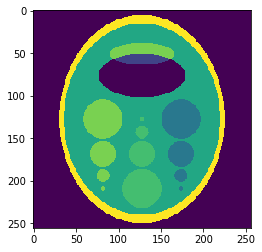

In [4]:
im = gen_phantom.gen_phantom(ndim=3, NN=(100,256,256))
plt.imshow(np.abs(im[50]))
print(im.shape)

In [5]:
start = time()
kg = gg.im2k(im)
end = time()
# print('Time: ', end-start, 's')
# print(np.diff(ttg))
# print(ttg[-1]-ttg[0])

In [6]:
start = time()
im2g = gg.k2im(kg)
end = time()
# print('Time: ', end-start, 's')
# print(np.diff(tt2g))
# print(tt2g[-1]-tt2g[0])

ERROR:  115.59965157159795


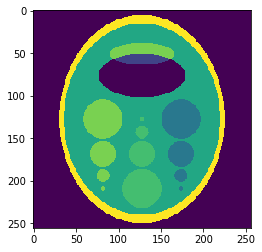

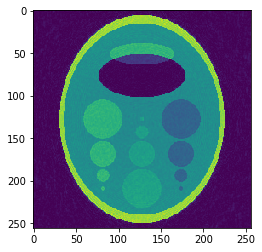

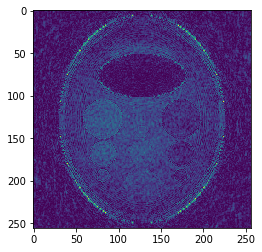

In [7]:
im = np.abs(im)
im2 = np.abs(im2g)

im2 /= im2.mean()/im.mean()

print('ERROR: ', np.linalg.norm(im-im2))

plt.figure()
plt.imshow(im[50])

plt.figure()
plt.imshow(im2[50])

plt.figure()
plt.imshow(np.abs(im2-im)[50])


In [ ]:
kg = None
im2g = None
gg = None

# del gg

In [ ]:
import cupy as cp
cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
print(cp.get_default_memory_pool().used_bytes())
print(cp.get_default_memory_pool().total_bytes())

In [ ]:
start = time()
k0, tt0 = gg.im2k(im, traj=k_all.astype(np.float32), dens=dens.astype(np.float32))
end = time()
print('Time: ', end-start, 's')
print(np.diff(tt0))
print(tt0[-1]-tt0[0])

In [ ]:
import cupy as cp
kk = cp.zeros(100, np.complex64)
kn = np.zeros(100, np.complex64)
print(hasattr(kk,'device'), hasattr(kn,'device'))

In [ ]:
cp.cuda.Stream.null.synchronize()

In [ ]:
diff = (np.abs(k0[:10000]) - np.abs(kg[:10000]))/np.abs(k0[:10000])
plt.plot(diff)

In [ ]:
im2 = gg.k2im(kg.get(), traj=k_all, dens=dens)

im = np.abs(im)
im2 = np.abs(im2)

im2 /= im2.mean()/im.mean()

print('ERROR: ', np.linalg.norm(im-im2))

plt.figure()
plt.imshow(im[128])

plt.figure()
plt.imshow(im2[128])

plt.figure()
plt.imshow(np.abs(im2-im)[128])

In [ ]:
plt.figure()
plt.imshow(im[:, 128])

plt.figure()
plt.imshow(im2[:, 128])

plt.figure()
plt.imshow(np.abs(im2-im)[:, 128])

In [ ]:
k_all.shape

In [ ]:
256*256

In [ ]:
import cupy as cp
add_kernel = cp.RawKernel(r'''
 #include <cupy/complex.cuh>
 extern "C" __global__
 void my_add(const float* x1, const float* x2, complex<float>* y) {
     int tid = blockDim.x * blockIdx.x + threadIdx.x;
     y[tid] = x1[tid] + x2[tid];
 }
''', 'my_add')
x1 = cp.arange(25, dtype=cp.float32).reshape(5, 5)
x2 = cp.arange(25, dtype=cp.float32).reshape(5, 5)
y = cp.zeros((5, 5), dtype=cp.complex64)
add_kernel((5,), (5,), (x1, x2, y))  # grid, block and arguments
y


In [ ]:
import cupy as cp
cp.cuda.Device().attributes

In [ ]:
b = np.float32(5.0)

In [ ]:
type(b)

In [ ]:
a = None
b = None

a is not None or b is not None

In [ ]:
256*256


In [ ]:
from functools import reduce
import cupy as cp

# NN = (256, 256, 256)
NN = (350, 450, 500)
# NN = (384, 384, 384)

A = np.random.random(NN) + 1j*np.random.random(NN)
A = A.astype(np.complex64)
print(A.shape)
D = []
for ii in range(3):
    D.append(np.linspace(-1.0, 1.0, A.shape[ii], dtype = np.float32))

E = A.copy()

start = time()
E /= ((D[2][np.newaxis, np.newaxis, :] * D[1][np.newaxis, :, np.newaxis]) * D[0][:, np.newaxis, np.newaxis])
end = time()
print('Time: ', end-start, 's')
    
B = A.copy()

start = time()
B /= D[2][np.newaxis, np.newaxis, :]
B /= D[1][np.newaxis, :, np.newaxis]
B /= D[0][:, np.newaxis, np.newaxis]
end = time()
print('Time: ', end-start, 's')

C = A.copy()

start = time()
C /= reduce(np.multiply.outer, D)
end = time()
print('Time: ', end-start, 's')


G = cp.asarray(A)
D2 = cp.asarray(D[2], np.float32)
D1 = cp.asarray(D[1], np.float32)
D0 = cp.asarray(D[0], np.float32)

start = time()
G /= ((D2[np.newaxis, np.newaxis, :] * D1[np.newaxis, :, np.newaxis]) * D0[:, np.newaxis, np.newaxis])
# G /= D2[np.newaxis, np.newaxis, :]
# G /= D1[np.newaxis, :, np.newaxis]
# G /= D0[:, np.newaxis, np.newaxis]
end = time()
print('Time: ', end-start, 's')

print(G.dtype, D0.dtype)

In [ ]:
deapp3 = cp.RawKernel(r'''
#include <cupy/complex.cuh>

extern "C" __global__
void deapp3(complex<float> *A, long *N, float *D0, float *D1, float *D2) 
{

int n_points = N[2] * N[1] * N[0];

for (int k = blockIdx.z * blockDim.z + threadIdx.z; 
         k < N[0]; 
         k += blockDim.z * gridDim.z) 
    {
for (int j = blockIdx.y * blockDim.y + threadIdx.y; 
         j < N[1]; 
         j += blockDim.y * gridDim.y) 
    {    
for (int i = blockIdx.x * blockDim.x + threadIdx.x; 
         i < N[2]; 
         i += blockDim.x * gridDim.x) 
    {
    
    A[k*N[2]*N[1] + j*N[2] + i] /= (D0[k] * D1[j] * D2[i]);
    //A[k*N[2]*N[1] + j*N[2] + i] = 1.0;
    //A[k*N[2]*N[1] + j*N[2] + i] = (D0[k] * D1[j] * D2[i]);
    
    
    }}}

}
''', 'deapp3')

F = cp.asarray(A)
Fs = cp.asarray(F.shape)
start = time()
deapp3((64,64,64), (8,8,8), (F, Fs, D0, D1, D2))
end = time()
print('Time: ', end-start, 's')

In [ ]:
np.allclose(F.get(), C)

In [ ]:
D2.shape

In [ ]:
Fs[2].dtype

In [ ]:
F.get() - C

In [ ]:
cp.cuda.Device().attributes

In [ ]:
8*8*8


In [ ]:
np.abs(D2).min()

In [ ]:
import cupy as cp
aa = cp.ones(1000, cp.complex64)

In [ ]:
type(aa.real)